First, we need to read the data into a network that can be read by gephi, using networkx. We create nodes for each user and video and connect them via edges for each entry in the table (as each entry consists of a 'triangle'). Of course, we do not want any duplicates or self loops. We can then, using notworkx, write the data to a gexf file, which can be read by gephi.

In [93]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv('pairwise_52seconds_share.csv')

G = nx.Graph()

for _, row in df.iterrows():
    user_1 = f"user_{row['userID_1']}"
    user_2 = f"user_{row['userID_2']}"
    video_node = f"video_{row['videoID']}"
    
    if not G.has_node(user_1):
        G.add_node(user_1, type='user', color='blue')
    
    if not G.has_node(user_2):
        G.add_node(user_2, type='user', color='blue')
        
    if not G.has_node(video_node):
        G.add_node(video_node, type='video', color='green')
        
    G.add_edge(user_1, video_node, timestamp=row['timestamp_1'])
    G.add_edge(user_2, video_node, timestamp=row['timestamp_2'])
    G.add_edge(user_2, user_1, timestamp=row['timestamp_1'])
    
G.remove_edges_from(nx.selfloop_edges(G))

In [94]:
nx.write_gexf(G, "blue_helm.gexf")


Using the number of nodes and edges from the base network, we can then generate various other network types, to compare them to the base network. We choose here a watts strogatz model and a barabasi albert model, as both of these simulate the social media structure that we are expecting from the base network, and in which we want to find irregularities. The parameters here are easily imputed from the base network, k (for watts strogatz) is simply the average amound of connections per node in the base network (2m/n), and p is set to 0.1. This is the same for barabasi-albert too.
We can then generate graphs for the network using gephi, utilising clustering algorithms like ForceAtlas2. This generates the following graph for our blue helm data network:
![Blue helm network](blue_helm.png)

In [95]:
n = G.number_of_nodes()
m = G.number_of_edges()

k = int((2 * m) / n)

H = nx.watts_strogatz_graph(n= n, k = k, p = 0.2)

nx.write_gexf(H, "watts_strogatz_random.gexf")

We then generate a watts strogatz graph, using the metrics defined above, yielding the following network:
![watts strogatz network](watts_strogatz.png)

In [96]:

m_par = int((2*m)/n)

K = nx.barabasi_albert_graph(n = n, m = m_par)

nx.write_gexf(K, "barabasi_albert.gexf")

we also generate the barabasi albert graph, which looks like this:
![barabasi albert graph](barabasi_albert.png)

We can already see that the structures of the networks are quite different, with the blue helm network being very hierarchical with lots of big hub nodes and smaller edge nodes. This is much less expressed in the two random networks, which are more distributed.

We can then define various metrics that we would like to assess for the different networks and apply them to compare.

In [100]:
# make sure to import python_louvain, not community
import community.community_louvain as community_louvain

# find triangles
def transitivity(net):
    return nx.transitivity(net)

# this one doesnt work for some reason
def rich_club(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.rich_club_coefficient(net_sub)

# average node degree (we might wanna make plots here to see how the degree varies in a curve, see below)
def average_degree(net):
    return sum(dict(net.degree()).values()) / net.number_of_nodes()

# dont put this in the compare network function
def plot_degree(net):
    degrees = [d for n, d in net.degree()]
    plt.hist(degrees, log = True)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

# this shows if nodes of similar degrees are connected (-1 to 1)
def deg_assortativity(net):
    return nx.degree_assortativity_coefficient(net)

# how likely are nodes neighbors also connected
def clustering_coefficient(net):
    return nx.average_clustering(net)

def diameter(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.diameter(net_sub)

def avg_shortest_path(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.average_shortest_path_length(net_sub)

# this is for whether the network is easily divisible into communities (densely connected sub areas) (between 0 and 1)
def modularity(net):
    partition_dict = community_louvain.best_partition(net)
    partition = []
    for community_id in set(partition_dict.values()):
        community_nodes = [node for node, community in partition_dict.items() if community == community_id]
        partition.append(community_nodes)
    return nx.algorithms.community.modularity(net, partition)

# related to this (also dont put this in the compare network function)
def plot_betweenness_centrality(net):
    betweenness = nx.betweenness_centrality(net)
    vals = list(betweenness.values())
    plt.hist(vals, bins  = 500, log = True)
    plt.title('Betweenness Centrality Distribution')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')
    plt.show()
    
def plot_betweenness_centraliy_mult(nets):
    n = len(nets)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False) 
    
    for i, net in enumerate(nets):
        betweenness = nx.betweenness_centrality(net)
        vals = list(betweenness.values())
        
        axs[0, i].hist(vals, bins=20, alpha=0.7, log=True)
        axs[0, i].set_title(f'Network {i+1}')
        axs[0, i].set_xlabel('Betweenness Centrality')
        axs[0, i].set_ylabel('Frequency')
    
    plt.suptitle('Betweenness Centrality Distributions')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()

def plot_deg_mult(nets):
    n = len(nets)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False) 
    for i, net in enumerate(networks):
        degrees = [d for n, d in net.degree()]
        
        axs[0, i].hist(degrees, bins=500, log=True, alpha=0.7)
        axs[0, i].set_title(f'Network {i+1}')
        axs[0, i].set_xlabel('Degree')
        axs[0, i].set_ylabel('Frequency (log scale)')
    
    plt.suptitle('Degree Distributions Across Networks')
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))  
    plt.show()

In [101]:
def compare_networks(net, base_networks):
    metrics = [transitivity, average_degree, deg_assortativity, diameter, avg_shortest_path, modularity]
    metric_names = [metric.__name__ for metric in metrics]
    
    results = {metric_name: [] for metric_name in metric_names}
    networks = [('blue_helm', net)] + [(f'baseline{i+1}', base_net) for i, base_net in enumerate(base_networks)]
    
    for name, network in networks:
        for metric in metrics:
            results[metric.__name__].append(metric(network))
            
    return results
    

In [88]:

result = compare_networks(G, [H, K])

We can show the results by just printing this dictionary. The metrics are in the same order as the input in the compare networks function input.

In [90]:
result

{'transitivity': [0.010092078570901202, 0, 0.005204094090835097],
 'average_degree': [3.8392857142857144, 2.0, 5.9958791208791204],
 'deg_assortativity': [-0.14743884690490577,
  -0.07680005517741138,
  -0.03754874147158474],
 'diameter': [17, 220, 7],
 'avg_shortest_path': [4.771102215238985,
  85.55188971949649,
  4.049053905791941],
 'modularity': [0.8117180955713218, 0.9688403853281944, 0.3884720274097663]}

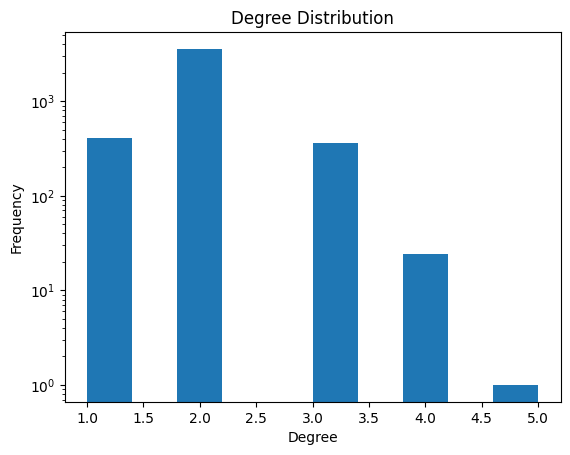

In [81]:
plot_degree(H)

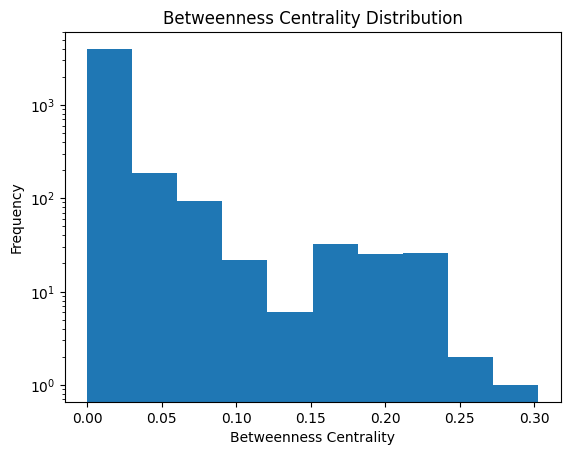

In [87]:
plot_betweenness_centrality(H)

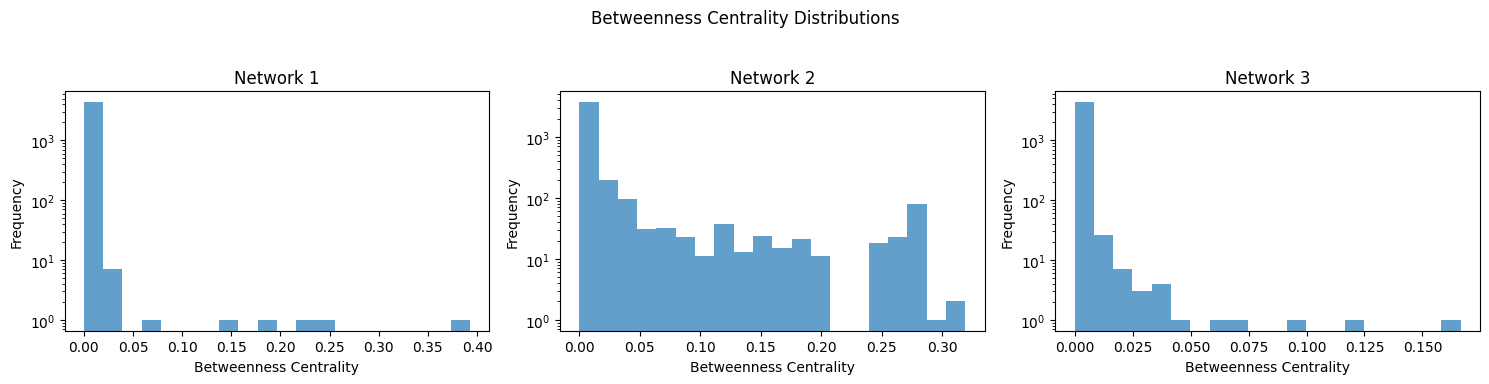

In [99]:
networks = [G,H,K]

plot_betweenness_centraliy_mult(networks)

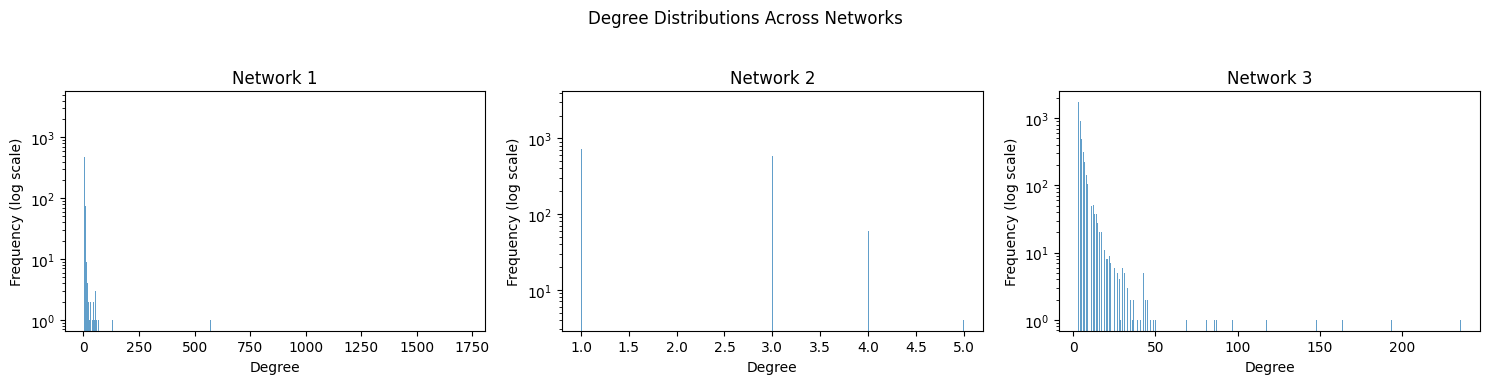

In [102]:
plot_deg_mult(networks)

In [ ]:
/